Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import graphviz 

Đọc và chuẩn bị dữ liệu

In [2]:
wine_data = pd.read_csv('winequality-red.csv', sep=';')

# Kiểm tra các tên cột và thông tin dữ liệu
print(wine_data.columns)  # In ra tên các cột
print(wine_data.head())   # Xem 5 dòng đầu tiên của dữ liệu
print(wine_data.info())   # Thông tin chi tiết về các cột và kiểu dữ liệu

# Giả sử nhãn đã có sẵn trong cột 'quality', và các đặc trưng là các cột còn lại
features_wine = wine_data.drop('quality', axis=1)
labels_wine = wine_data['quality']

# Gom nhóm các lớp chất lượng thành 3 nhóm: Low (0-4), Standard (5-6), High (7-10)
labels_wine = labels_wine.apply(lambda x: 0 if x <= 4 else (1 if x <= 6 else 2))

# Chia dữ liệu thành train/test theo các tỷ lệ khác nhau
def stratified_split(X, y, train_size, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Chỉnh sửa y[train_index] thành y.iloc[train_index]
    return X_train, X_test, y_train, y_test

train_test_ratios = [0.4, 0.6, 0.8, 0.9]
splits_wine = {}  # Dictionary để lưu các tập dữ liệu

# Chia dữ liệu theo các tỷ lệ train/test khác nhau
for ratio in train_test_ratios:
    X_train, X_test, y_train, y_test = stratified_split(features_wine, labels_wine, train_size=ratio)
    splits_wine[ratio] = (X_train, X_test, y_train, y_test)

# In ra thông tin về các tập dữ liệu đã chia
for ratio, (X_train, X_test, y_train, y_test) in splits_wine.items():
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}, Ratio: {ratio}")


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3        

Trực quan hóa phân bố lớp

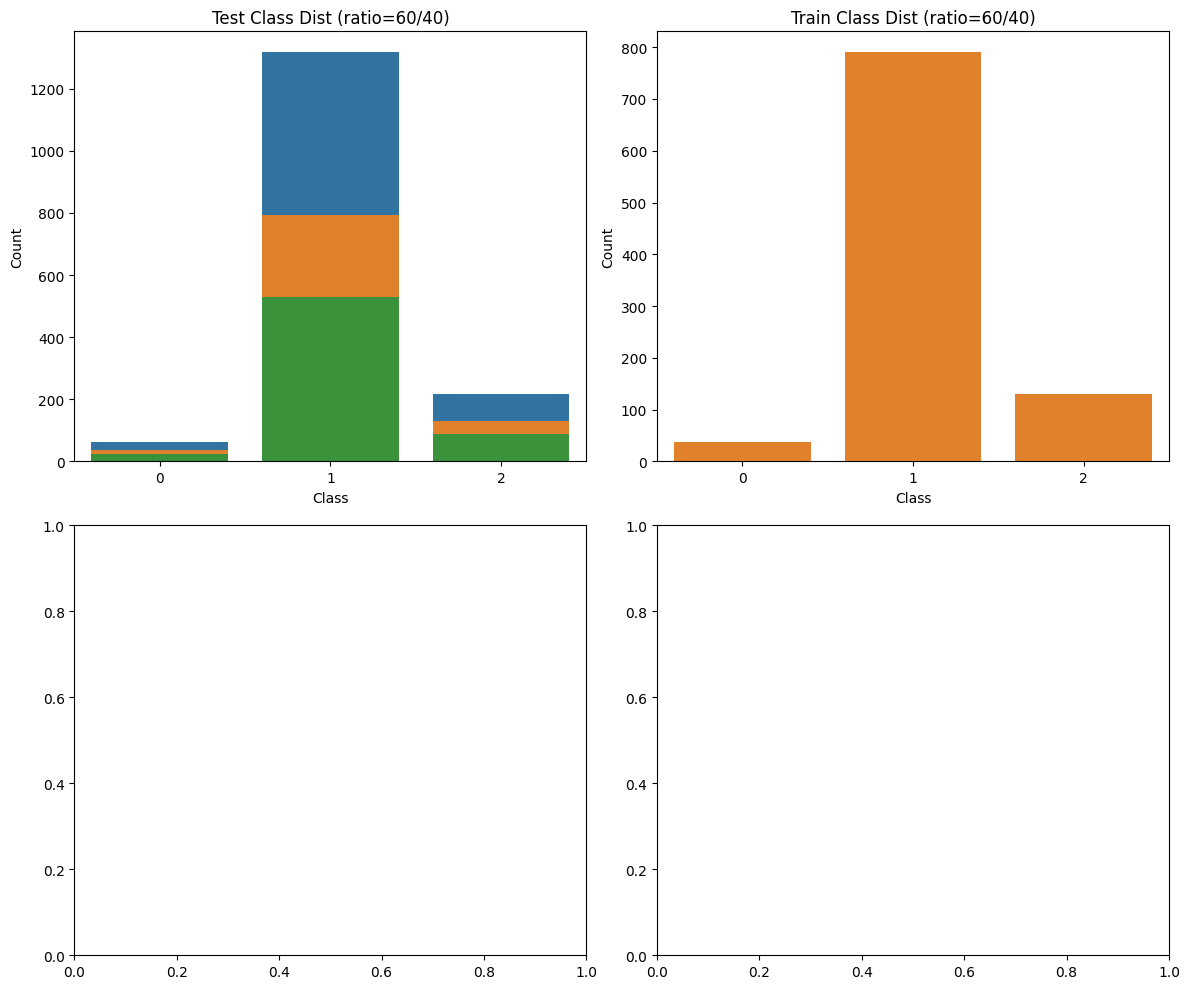

In [3]:
# Hàm vẽ phân bố lớp
def plot_class_distribution(ax, y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)
    sns.barplot(x=unique, y=counts, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

# Tạo grid cho các biểu đồ con (2 hàng, 2 cột)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Vẽ phân bố lớp cho bộ dữ liệu gốc (biểu đồ ở vị trí [0, 0])
plot_class_distribution(axes[0, 0], labels_wine, title="Original Data Class Distribution")

# Vẽ phân bố lớp cho các tỷ lệ train/test
for i, ratio in enumerate(train_test_ratios[:2]):  # Duyệt qua 2 tỷ lệ đầu tiên
    X_train, X_test, y_train, y_test = splits_wine[ratio]
    
    # Vẽ phân bố lớp cho dữ liệu train (lựa chọn vị trí trong grid)
    plot_class_distribution(axes[i//2, 1], y_train, title=f"Train Class Dist (ratio={int(ratio*100)}/{int((1-ratio)*100)})")
    
    # Vẽ phân bố lớp cho dữ liệu test (lựa chọn vị trí trong grid)
    plot_class_distribution(axes[i//2, 0], y_test, title=f"Test Class Dist (ratio={int(ratio*100)}/{int((1-ratio)*100)})")

# Điều chỉnh khoảng cách giữa các biểu đồ con
plt.tight_layout()
plt.show()

Huấn luyện mô hình Decision Tree và trực quan hóa cây

In [4]:
def train_and_visualize_decision_tree(X_train, y_train, max_depth=None):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    return dt

def visualize_tree(dt, feature_names, class_names):
    dot_data = export_graphviz(
        dt, 
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

# Lặp qua các tỷ lệ phân chia dữ liệu và huấn luyện, vẽ cây quyết định
for ratio in train_test_ratios:
    X_train, X_test, y_train, y_test = splits_wine[ratio]
    
    # Huấn luyện cây quyết định
    dt_model = train_and_visualize_decision_tree(X_train, y_train, max_depth=None)
    
    # Vẽ cây quyết định
    graph = visualize_tree(dt_model, feature_names=X_train.columns, class_names=['Low', 'Standard', 'High'])
    
    # Xuất cây quyết định ra file hình ảnh
    graph.render(f"decision_tree_wine_{int(ratio*100)}_{int((1-ratio)*100)}", format='png', cleanup=True)


Đánh giá mô hình

In [5]:
def evaluate_model(dt, X_test, y_test):
    y_pred = dt.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    return acc

# Đánh giá mô hình vừa huấn luyện
acc = evaluate_model(dt_model, X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.91      0.89      0.90       132
           2       0.60      0.68      0.64        22

    accuracy                           0.83       160
   macro avg       0.50      0.53      0.51       160
weighted avg       0.83      0.83      0.83       160

Confusion Matrix:
[[  0   5   1]
 [  5 118   9]
 [  0   7  15]]
Accuracy: 0.83125


Khảo sát ảnh hưởng của max_depth

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.91      0.89      0.90       132
           2       0.60      0.68      0.64        22

    accuracy                           0.83       160
   macro avg       0.50      0.53      0.51       160
weighted avg       0.83      0.83      0.83       160

Confusion Matrix:
[[  0   5   1]
 [  5 118   9]
 [  0   7  15]]
Accuracy: 0.83125
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.82      1.00      0.90       132
           2       0.00      0.00      0.00        22

    accuracy                           0.82       160
   macro avg       0.27      0.33      0.30       160
weighted avg       0.68      0.82      0.75       160

Confusion Matrix:
[[  0   6   0]
 [  0 132   0]
 [  0  22   0]]
Accuracy: 0.825
Classification Report:
       

c:\Users\ngoct\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ngoct\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ngoct\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

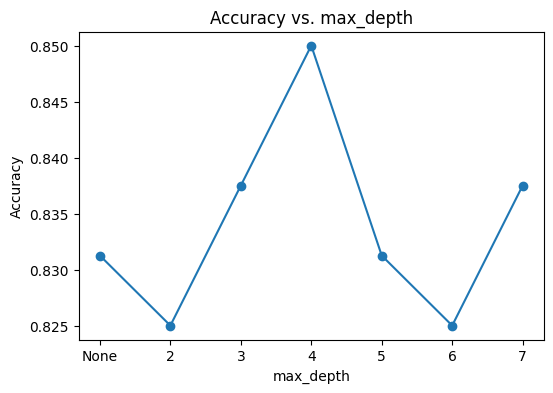

In [6]:
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

for md in max_depth_values:
    dt_model_md = train_and_visualize_decision_tree(X_train, y_train, max_depth=md)
    acc_md = evaluate_model(dt_model_md, X_test, y_test)
    accuracies.append(acc_md)

# Vẽ biểu đồ thể hiện sự thay đổi accuracy theo max_depth
plt.figure(figsize=(6,4))
plt.plot([str(m) for m in max_depth_values], accuracies, marker='o')
plt.title("Accuracy vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.show()
